<a id='0.1'></a>
## 0.1 load required packages

In [1]:
%run "..\..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *

print(os.getpid())

# library design specific tools
from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

21400


In [3]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain'
if not os.path.exists(pool_folder):
    print(f"Create pool_folder: {pool_folder}")
    os.makedirs(pool_folder)
else:
    print(f"Use pool_folder: {pool_folder}")
    
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'human_genome_library')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)

Use pool_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain


## 3.1 design readout mapping dict (region_to_readout)

idea for this library:

1. each gene has 3 on-bits from 99 total-bits

3. 

In [5]:
on_num = 3
total_num = 99

encoding_file = os.path.join(library_folder, f'covering_v_{total_num}_k_{on_num}_t_2.txt')
loaded_bits = []

with open(encoding_file, 'r') as _handle:
    # start reading
    _lines = _handle.read().split('\n')
    for _line in _lines:
        _bits = [int(_i)-1 for _i in _line.split(' ') if len(_i) > 0]
        loaded_bits.append(_bits)

loaded_bits = np.array(loaded_bits, dtype=np.int32)
print(np.shape(loaded_bits))

(1617, 3)


In [9]:
def convert_bits_to_matrix(bits):
    _matrix = np.ones([len(bits), np.max(bits)+1], dtype=np.int32) * -1
    for _i, _b in enumerate(bits):
        _matrix[_i, _b] = 1
    return _matrix

In [10]:
# remove redundant bits
kept_bits = loaded_bits.copy()
kept_inds = np.zeros(len(kept_bits))
while np.sum(kept_inds) != len(kept_inds):
    kept_inds = np.ones(len(kept_bits), dtype=bool)
    _kept_mat = convert_bits_to_matrix(kept_bits)
    _dists = (total_num - (_kept_mat @ _kept_mat.T)) / 2
    _x, _y = np.where((_dists > 0) * (_dists <= 3))
    if len(_x) > 0:
        kept_inds[_x[0]] = False
        kept_bits = kept_bits[kept_inds]
        print(np.sum(kept_inds), kept_inds[_x[0]])
print(kept_bits.shape)

(1617, 3)


In [11]:
encoding_bits = kept_bits.copy()
encoding_mat = convert_bits_to_matrix(encoding_bits)

In [12]:
encoding_folder = os.path.join(library_folder, 'Encoding_design')
if not os.path.exists(encoding_folder):
    os.makedirs(encoding_folder)
    print(encoding_folder)

pickle.dump(encoding_bits, open(os.path.join(encoding_folder, f'encoding_bits_total-{total_num}_on-{on_num}'), 'wb'))

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\Encoding_design


In [14]:
chr_2_region_num = pickle.load( open(os.path.join(library_folder, 'chr_2_final_region_num.pkl'), 'rb'))

In [19]:
# assign into different chromosomes
cand_bits = list(encoding_bits)
total_bit_usage = np.zeros(np.max(cand_bits)+1)
chr_bit_usage_dict = {}
chr_2_region_bits = {}
for _chr, _num in sorted(chr_2_region_num.items(), key=lambda v:-v[1]):
    print(_chr, _num)
    chr_2_region_bits[_chr] = []
    # try to assign as even as possible for this chr
    _chr_bit_usage = np.zeros(np.max(cand_bits)+1)
    
    while len(chr_2_region_bits[_chr]) < _num:
        # for each cand_bit, estimate overlap
        _chr_usage_list = [np.sum(_chr_bit_usage[_bits]**2) for _bits in cand_bits]
        _total_usage_list = [np.sum(total_bit_usage[_bits]**2) for _bits in cand_bits]
        # find the least overlapping candidate
        _least_overlap_inds = []
        _chr_usage_th = np.min(_chr_usage_list)
        _total_usage_th = np.min(_total_usage_list)
        while len(_least_overlap_inds) == 0:
            _least_overlap_inds = np.intersect1d(np.where(np.array(_chr_usage_list)<=_chr_usage_th)[0], 
                                                np.where(np.array(_total_usage_list)<=_total_usage_th)[0])
            _total_usage_th += 1
        
        _rand_least_overlap_ind = _least_overlap_inds[np.random.randint(len(_least_overlap_inds))]
        
        print(_chr_bit_usage[cand_bits[_rand_least_overlap_ind]], 
              total_bit_usage[cand_bits[_rand_least_overlap_ind]],  
              cand_bits[_rand_least_overlap_ind],
              )
        
        
        # remove this code from cand_bit pool
        _sel_cand = cand_bits.pop(_rand_least_overlap_ind)


        # update overlap list and chr_2_region_bits
        chr_2_region_bits[_chr].append(_sel_cand)
        _chr_bit_usage[_sel_cand] += 1
        total_bit_usage[_sel_cand] += 1
    
    chr_bit_usage_dict[_chr] = _chr_bit_usage

2 90
[0. 0. 0.] [0. 0. 0.] [20 28 36]
[0. 0. 0.] [0. 0. 0.] [15 23 50]
[0. 0. 0.] [0. 0. 0.] [12 34 42]
[0. 0. 0.] [0. 0. 0.] [14 18 27]
[0. 0. 0.] [0. 0. 0.] [37 58 63]
[0. 0. 0.] [0. 0. 0.] [16 90 95]
[0. 0. 0.] [0. 0. 0.] [ 3 86 89]
[0. 0. 0.] [0. 0. 0.] [ 7 29 32]
[0. 0. 0.] [0. 0. 0.] [ 0 51 59]
[0. 0. 0.] [0. 0. 0.] [52 55 73]
[0. 0. 0.] [0. 0. 0.] [67 92 98]
[0. 0. 0.] [0. 0. 0.] [ 4 54 81]
[0. 0. 0.] [0. 0. 0.] [61 74 79]
[0. 0. 0.] [0. 0. 0.] [ 2 57 82]
[0. 0. 0.] [0. 0. 0.] [ 6 24 30]
[0. 0. 0.] [0. 0. 0.] [40 44 60]
[0. 0. 0.] [0. 0. 0.] [ 8 80 87]
[0. 0. 0.] [0. 0. 0.] [17 43 96]
[0. 0. 0.] [0. 0. 0.] [46 62 88]
[0. 0. 0.] [0. 0. 0.] [11 26 49]
[0. 0. 0.] [0. 0. 0.] [19 64 93]
[0. 0. 0.] [0. 0. 0.] [22 25 78]
[0. 0. 0.] [0. 0. 0.] [13 76 84]
[0. 0. 0.] [0. 0. 0.] [45 56 65]
[0. 0. 0.] [0. 0. 0.] [41 71 97]
[0. 0. 0.] [0. 0. 0.] [75 77 83]
[0. 0. 0.] [0. 0. 0.] [48 66 85]
[0. 0. 0.] [0. 0. 0.] [35 39 72]
[0. 0. 0.] [0. 0. 0.] [ 9 70 94]
[0. 0. 0.] [0. 0. 0.] [21 33 91]
[0. 0

[2. 2. 2.] [7. 7. 7.] [11 77 93]
4 74
[0. 0. 0.] [7. 7. 7.] [ 4 33 76]
[0. 0. 0.] [7. 7. 7.] [52 59 66]
[0. 0. 0.] [7. 7. 7.] [51 57 67]
[0. 0. 0.] [7. 7. 7.] [29 53 92]
[0. 0. 0.] [7. 7. 7.] [37 68 98]
[0. 0. 0.] [7. 7. 7.] [70 80 89]
[0. 0. 0.] [7. 7. 7.] [49 55 82]
[0. 0. 0.] [7. 7. 7.] [ 6 38 63]
[0. 0. 0.] [7. 7. 7.] [ 5 35 74]
[0. 0. 0.] [7. 7. 7.] [14 32 45]
[0. 0. 0.] [7. 8. 7.] [34 43 48]
[0. 0. 0.] [8. 7. 7.] [20 42 61]
[0. 0. 0.] [7. 7. 8.] [75 79 97]
[0. 0. 0.] [7. 7. 8.] [18 23 40]
[0. 0. 0.] [7. 8. 8.] [15 54 69]
[0. 0. 0.] [8. 8. 8.] [ 8 25 64]
[0. 0. 0.] [8. 8. 8.] [17 36 87]
[0. 0. 0.] [8. 8. 8.] [10 71 91]
[0. 0. 0.] [8. 8. 8.] [47 50 86]
[0. 0. 0.] [8. 8. 8.] [30 31 62]
[0. 0. 0.] [8. 8. 8.] [13 21 58]
[0. 0. 0.] [8. 8. 8.] [ 9 24 77]
[0. 0. 0.] [8. 8. 8.] [ 7 60 65]
[0. 0. 0.] [8. 8. 8.] [ 0 12 73]
[0. 0. 0.] [8. 8. 8.] [ 2 19 22]
[0. 0. 0.] [8. 8. 8.] [16 28 94]
[0. 0. 0.] [8. 8. 8.] [ 3 26 90]
[0. 0. 0.] [8. 8. 8.] [41 78 93]
[0. 0. 0.] [8. 8. 8.] [39 84 88]
[0. 1

[0. 0. 0.] [14. 14. 14.] [ 9 31 80]
[0. 0. 0.] [15. 14. 14.] [32 65 68]
[1. 0. 0.] [14. 14. 14.] [ 4 47 92]
[0. 1. 0.] [14. 14. 14.] [22 35 86]
[1. 0. 0.] [15. 14. 14.] [ 5 79 91]
[1. 0. 0.] [15. 14. 14.] [49 64 89]
[0. 0. 1.] [15. 14. 14.] [12 74 75]
[0. 1. 0.] [14. 15. 15.] [29 42 51]
[1. 1. 1.] [15. 14. 14.] [31 70 93]
[1. 1. 1.] [15. 14. 14.] [41 45 82]
[1. 1. 1.] [15. 14. 14.] [10 57 76]
[1. 1. 1.] [14. 15. 14.] [ 6 36 66]
[1. 1. 1.] [14. 15. 15.] [33 62 87]
[1. 1. 1.] [15. 15. 15.] [46 74 81]
[1. 1. 1.] [15. 15. 15.] [18 20 37]
[1. 1. 1.] [15. 15. 15.] [ 3 27 59]
[1. 1. 1.] [15. 15. 15.] [55 89 97]
[1. 1. 1.] [15. 15. 15.] [ 2 16 67]
[1. 1. 1.] [15. 15. 15.] [54 90 94]
[1. 1. 1.] [15. 15. 15.] [48 58 83]
[1. 1. 1.] [15. 15. 15.] [71 85 92]
[1. 1. 1.] [15. 15. 15.] [ 9 22 28]
[1. 1. 1.] [15. 15. 15.] [13 24 52]
[1. 1. 1.] [15. 15. 15.] [15 29 78]
[1. 1. 1.] [15. 15. 15.] [11 30 61]
[1. 1. 1.] [15. 15. 15.] [26 80 84]
[1. 1. 1.] [15. 15. 15.] [21 88 98]
[1. 1. 1.] [15. 15. 15.] [56

[0. 0. 0.] [21. 22. 21.] [ 0 36 89]
[0. 0. 0.] [21. 22. 21.] [21 64 82]
[0. 0. 0.] [21. 21. 22.] [ 5 61 87]
[0. 0. 0.] [21. 22. 21.] [ 4 56 91]
[0. 0. 0.] [22. 21. 21.] [23 45 53]
[0. 0. 0.] [21. 22. 21.] [33 54 78]
[0. 0. 0.] [22. 22. 21.] [26 47 95]
[0. 0. 0.] [22. 22. 22.] [ 2 58 97]
[0. 0. 0.] [22. 22. 22.] [10 29 34]
[0. 0. 0.] [22. 22. 22.] [59 84 86]
[0. 0. 0.] [22. 22. 22.] [ 1 37 43]
[0. 0. 0.] [22. 22. 22.] [65 69 94]
[0. 0. 0.] [22. 22. 22.] [14 22 49]
[0. 0. 0.] [22. 22. 22.] [42 83 92]
[1. 0. 0.] [22. 22. 22.] [31 35 85]
[0. 1. 0.] [22. 22. 22.] [16 24 98]
[0. 0. 1.] [22. 22. 22.] [41 77 89]
[0. 1. 0.] [22. 22. 22.] [15 38 62]
[0. 1. 1.] [22. 22. 22.] [55 88 96]
[1. 1. 1.] [22. 22. 22.] [ 8 17 78]
[1. 1. 1.] [22. 22. 22.] [61 71 72]
[1. 1. 1.] [22. 22. 22.] [27 76 91]
[1. 1. 1.] [22. 22. 22.] [11 68 74]
[1. 1. 1.] [22. 22. 22.] [60 63 75]
[1. 1. 1.] [22. 22. 22.] [39 67 70]
[1. 1. 1.] [22. 22. 22.] [ 0  5 32]
[1. 1. 1.] [22. 22. 22.] [30 50 51]
[1. 1. 1.] [22. 22. 22.] [ 9

[0. 0. 0.] [28. 28. 28.] [36 51 52]
[0. 0. 0.] [28. 28. 28.] [18 64 86]
[0. 0. 0.] [28. 28. 28.] [12 39 82]
[0. 0. 0.] [28. 28. 28.] [ 3 83 98]
[0. 0. 0.] [28. 29. 28.] [29 35 48]
[0. 0. 0.] [29. 28. 28.] [25 69 91]
[0. 0. 0.] [28. 28. 29.] [13 31 77]
[0. 0. 0.] [28. 28. 29.] [ 7 27 61]
[0. 0. 0.] [29. 29. 28.] [ 0 60 74]
[0. 0. 0.] [29. 28. 29.] [21 28 55]
[0. 0. 0.] [29. 29. 28.] [16 26 73]
[0. 0. 0.] [29. 29. 29.] [58 59 80]
[0. 0. 0.] [29. 29. 29.] [15 57 65]
[0. 0. 1.] [28. 29. 29.] [ 2 62 63]
[1. 0. 0.] [29. 29. 29.] [52 78 92]
[0. 0. 1.] [29. 29. 29.] [23 68 88]
[1. 0. 0.] [29. 29. 29.] [29 47 87]
[0. 1. 0.] [29. 29. 29.] [46 49 84]
[0. 1. 0.] [29. 29. 29.] [ 6 74 90]
[1. 0. 0.] [29. 29. 29.] [38 43 45]
[1. 0. 1.] [29. 29. 29.] [ 2 24 50]
[1. 1. 0.] [29. 29. 29.] [10 30 85]
[1. 1. 0.] [29. 29. 29.] [33 34 94]
[1. 0. 1.] [29. 29. 29.] [ 9 53 81]
[1. 1. 1.] [29. 29. 29.] [ 8 32 39]
[1. 1. 1.] [29. 29. 29.] [14 44 67]
[1. 1. 1.] [29. 29. 29.] [20 51 54]
[1. 1. 1.] [29. 29. 29.] [ 4

[0. 0. 0.] [36. 36. 36.] [41 81 85]
[0. 0. 0.] [36. 36. 36.] [18 29 73]
[0. 0. 0.] [36. 36. 36.] [21 60 83]
[0. 0. 0.] [36. 36. 36.] [20 38 66]
[0. 0. 0.] [36. 36. 36.] [19 39 58]
[0. 0. 0.] [36. 36. 36.] [26 46 77]
[0. 0. 0.] [36. 36. 36.] [31 34 79]
[0. 0. 0.] [36. 36. 36.] [35 52 89]
[0. 0. 0.] [36. 36. 36.] [12 16 44]
[0. 0. 0.] [36. 36. 36.] [23 76 86]
[0. 0. 0.] [36. 36. 36.] [63 69 84]
[0. 0. 0.] [36. 36. 36.] [28 59 98]
[0. 0. 0.] [36. 36. 36.] [ 9 30 43]
[0. 0. 0.] [36. 36. 36.] [ 6 22 68]
[0. 0. 0.] [36. 36. 36.] [24 42 62]
[0. 0. 0.] [36. 36. 36.] [40 88 93]
[0. 0. 0.] [36. 36. 36.] [ 3 36 74]
[0. 0. 0.] [36. 36. 36.] [13 37 75]
[1. 0. 0.] [36. 36. 36.] [2 5 8]
[1. 0. 0.] [37. 36. 36.] [38 87 90]
[1. 0. 0.] [37. 36. 36.] [20 27 96]
[1. 0. 0.] [37. 36. 36.] [31 45 71]
[0. 1. 0.] [36. 37. 36.] [ 1 19 53]
[1. 0. 0.] [37. 36. 36.] [ 7 15 70]
[1. 0. 0.] [37. 36. 36.] [49 78 97]
[0. 1. 0.] [36. 37. 36.] [50 61 91]
[0. 1. 0.] [36. 37. 36.] [47 48 64]
[1. 0. 0.] [37. 37. 36.] [26 33

<IPython.core.display.Javascript object>


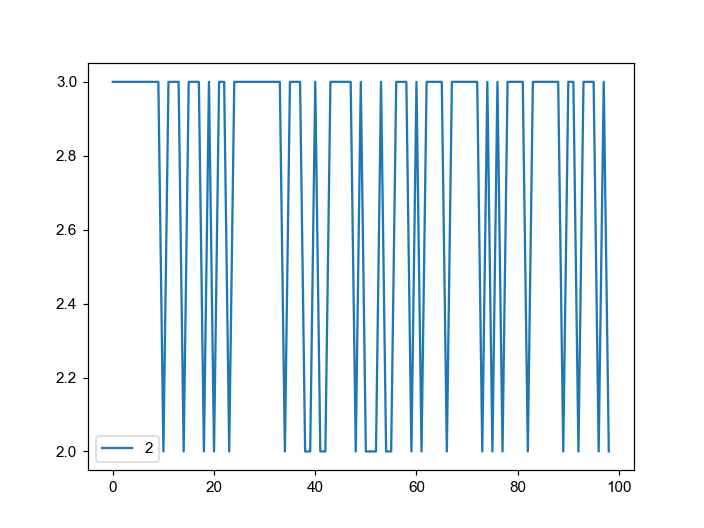

In [20]:
fig, ax = plt.subplots()
for _chr, _chr_bit_usage in chr_bit_usage_dict.items():
    ax.plot(_chr_bit_usage, label=_chr, )
    break
ax.legend()

In [42]:
def calculate_closest_overlap(code_list, code, _localtion):
    """Calculate the closest neighbor of certain code at certain location"""
    if _localtion > len(code_list) or _localtion < 0:
        raise ValueError(f"invalid _location")
    _code_list = np.array(code_list)
    if len(_code_list) == 0:
        return np.inf
    else:
        _min_dists = []
        for _c in code:
            if not (_code_list==_c).any():
                _min_dists.append(len(code_list)+1)
            else:
                _match_loc,_  = np.where(_code_list == _c)
                _dists = np.abs(_match_loc - _localtion)
                _dists[_match_loc >= _localtion] += 1
                _min_dists.append(np.min(_dists))
        #print(_min_dists)
    return np.nanmin(_min_dists).astype(np.float64)

In [45]:
sorted_chr_bits = {}
sorted_chr_dists = {}
for _chr, _chr_bits in chr_bit_usage_dict.items():
    print('Chr', _chr)
    _chr_bits = np.array(chr_2_region_bits[_chr])
    code_degrees = np.array([np.sum(chr_bit_usage_dict[_chr][_b])-3 for _b in _chr_bits])

    final_codes = []
    final_dist = 0

    # it seems the random doesnt help
    for _iter in range(1000):
        ordered_codes = []
        #ordered_codes = [tuple(_c) for _c in _chr_bits[np.where(code_degrees==np.min(code_degrees))]]
        #random.shuffle(ordered_codes)
        #for _degree in np.unique(code_degrees)[1:]:
        for _degree in np.unique(code_degrees):
            _cand_codes = [tuple(_c) for _c in _chr_bits[np.where(code_degrees==_degree)]]
            #print(_cand_codes, len(_cand_codes))
            #random.shuffle(_cand_codes)
            #print(_cand_codes, len(_cand_codes))
            for _code in _cand_codes:
                _dists = []
                for _i in range(0, len(ordered_codes)+1):
                    _dists.append(calculate_closest_overlap(ordered_codes, _code, _i))
                ordered_codes.insert(np.argmax(_dists), _code)
                #print(_dists, np.argmax(_dists))

        # check order
        final_dists = []
        for _i, _code in enumerate(ordered_codes):
            _other_codes = [_c for _j, _c in enumerate(ordered_codes) if _i != _j]
            final_dists.append(calculate_closest_overlap(_other_codes, _code, _i))
        if min(final_dists) > final_dist:
            final_dist = np.nanmin(final_dists)
            final_codes = [np.array(_c) for _c in ordered_codes]
            print('min dist:', final_dist, 'change')
        
        #break
    sorted_chr_bits[_chr] = np.array(final_codes)
    sorted_chr_dists[_chr] = np.array(final_dists)

Chr 2
min dist: 4.0 change
Chr 1
min dist: 7.0 change
Chr 3
min dist: 13.0 change
Chr 4
min dist: 9.0 change
Chr 5
min dist: 13.0 change
Chr 10
min dist: 2.0 change
Chr 6
min dist: 5.0 change
Chr 12
min dist: 9.0 change
Chr 11
min dist: 9.0 change
Chr 20
min dist: 8.0 change
Chr 7
min dist: 10.0 change
Chr X
min dist: 10.0 change
Chr 14
min dist: 8.0 change
Chr 8
min dist: 10.0 change
Chr 9
min dist: 6.0 change
Chr 19
min dist: 9.0 change
Chr 15
min dist: 11.0 change
Chr 13
min dist: 9.0 change
Chr 16
min dist: 9.0 change
Chr 18
min dist: 9.0 change
Chr 17
min dist: 8.0 change
Chr 21
min dist: 29.0 change
Chr 22
min dist: 26.0 change
Chr Y
min dist: 14.0 change


# region to bits

In [46]:
# load
chr_2_region_names = pickle.load(open(os.path.join(library_folder,'chr_2_region_names.pkl'), 'rb'))

In [47]:
# assemble to regionrate region_to_encoding_bits
region_2_bits = {}
for _chr in sorted_chr_bits:
    _chr_bits = sorted_chr_bits[_chr]
    _region_names = chr_2_region_names[_chr]
    print(_chr, len(_chr_bits), len(_region_names))
    region_2_bits.update({_g:_b for _g, _b in zip(_region_names, _chr_bits)})

2 90 90
1 84 84
3 77 77
4 74 74
5 69 69
10 65 65
6 64 64
12 62 62
11 61 61
20 60 60
7 59 59
X 59 59
14 56 56
8 55 55
9 53 53
19 53 53
15 49 49
13 48 48
16 48 48
18 47 47
17 46 46
21 30 30
22 29 29
Y 14 14


In [48]:
pickle.dump(region_2_bits, open(os.path.join(encoding_folder, f'region_2_bits.pkl'), 'wb'))

In [51]:
len(region_2_bits)

1352

In [50]:
region_2_readout_dict = {}
for _iregion, _region in enumerate(region_2_bits):
    region_2_readout_dict[_region] = []#[f"u{_iregion}"]
    region_2_readout_dict[_region].extend([f"c{_b}" for _b in region_2_bits[_region]])

# save
pickle.dump(region_2_readout_dict, open(os.path.join(library_folder, 'region_2_readout.pkl'), 'wb'))